# Dive Prediction - Time Series Deep Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 600s
* *Output resolution*: 60s
* *Representation of trajectories* : Time Series
* *Layers* : deep convolutions




## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [6]:
data_train = pd.read_csv('./data/data_train.csv')
data_validation = pd.read_csv('./data/data_validation.csv')
data_test = pd.read_csv('./data/data_test.csv')

In [7]:
def standardize(var):
    var = np.array(var)
    return (var-np.mean(var))/np.std(var)

def standardize_minmax(var):
    var = np.array(var)
    return (var-np.min(var))/(np.max(var) - np.min(var))

In [8]:
data_train = data_train.copy()
data_train = data_train.dropna()
data_train['lon_std'] = 0
data_train['lat_std'] = 0
data_train['step_speed_std'] = 0
data_train['step_direction_cos'] = 0
data_train['step_direction_sin'] = 0
    
for trip in data_train.trip.unique():
    data_train.loc[data_train.trip == trip,'lon_std'] = standardize(data_train.loc[data_train.trip == trip,'lon'])
    data_train.loc[data_train.trip == trip, 'lat_std'] = standardize(data_train.loc[data_train.trip == trip,'lat'])
    data_train.loc[data_train.trip == trip,'step_speed_std'] = standardize_minmax(data_train.loc[data_train.trip == trip,'step_speed'])
    data_train.loc[data_train.trip == trip,'step_direction_cos'] = np.cos(data_train.loc[data_train.trip == trip,'step_direction']* np.pi/180)
    data_train.loc[data_train.trip == trip,'step_direction_sin'] = np.sin(data_train.loc[data_train.trip == trip,'step_direction']* np.pi/180)
data_train.head()

,trip,datetime,lon,lat,pressure,gaps,step_speed,step_direction,dive,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_46_SV_T1,2008-12-05 15:12:41,-77.262442,-11.773072,-0.26,False,7.224129,3.984122,0,1.452647,1.542331,0.246157,0.997583,0.069480
3,P1108_46_SV_T1,2008-12-05 15:12:42,-77.262447,-11.773147,-0.26,False,8.366185,13.285157,0,1.452565,1.541362,0.285681,0.973238,0.229798
4,P1108_46_SV_T1,2008-12-05 15:12:43,-77.262482,-11.773217,-0.22,False,8.675223,22.346828,0,1.451995,1.540458,0.296376,0.924899,0.380212
5,P1108_46_SV_T1,2008-12-05 15:12:44,-77.262517,-11.773293,-0.29,False,9.279737,-1.813227,0,1.451424,1.539476,0.317297,0.999499,-0.031641
6,P1108_46_SV_T1,2008-12-05 15:12:45,-77.262518,-11.773372,-0.19,False,8.794348,-23.557701,0,1.451408,1.538456,0.300499,0.916658,-0.399672


In [9]:
data_validation = data_validation.copy()
data_validation = data_validation.dropna()
data_validation['lon_std'] = 0
data_validation['lat_std'] = 0
data_validation['step_speed_std'] = 0
data_validation['step_direction_cos'] = 0
data_validation['step_direction_sin'] = 0
    
for trip in data_validation.trip.unique():
    data_validation.loc[data_validation.trip == trip,'lon_std'] = standardize(data_validation.loc[data_validation.trip == trip,'lon'])
    data_validation.loc[data_validation.trip == trip, 'lat_std'] = standardize(data_validation.loc[data_validation.trip == trip,'lat'])
    data_validation.loc[data_validation.trip == trip,'step_speed_std'] = standardize_minmax(data_validation.loc[data_validation.trip == trip,'step_speed'])
    data_validation.loc[data_validation.trip == trip,'step_direction_cos'] = np.cos(data_validation.loc[data_validation.trip == trip,'step_direction']* np.pi/180)
    data_validation.loc[data_validation.trip == trip,'step_direction_sin'] = np.sin(data_validation.loc[data_validation.trip == trip,'step_direction']* np.pi/180)
data_validation.head()

,trip,datetime,lon,lat,pressure,gaps,step_speed,step_direction,dive,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1111_27_SV_T2,2011-11-20 18:50:58,-77.264490,-11.773268,-0.19,False,11.085434,0.000003,0,1.792706,-2.551831,0.334074,1.000000,5.213293e-08
3,P1111_27_SV_T2,2011-11-20 18:50:59,-77.264495,-11.773133,-0.13,True,15.037037,-10.555752,0,1.792384,-2.543389,0.453161,0.983077,-1.831922e-01
4,P1111_27_SV_T2,2011-11-20 18:51:00,-77.264500,-11.772998,-0.13,False,15.037037,-0.000001,0,1.792062,-2.534948,0.453161,1.000000,-1.787402e-08
5,P1111_27_SV_T2,2011-11-20 18:51:01,-77.264546,-11.772912,-0.13,True,10.855183,-25.425193,0,1.789099,-2.529539,0.327136,0.903147,-4.293323e-01
6,P1111_27_SV_T2,2011-11-20 18:51:02,-77.264592,-11.772825,-0.19,False,10.855184,-0.000007,0,1.786136,-2.524131,0.327136,1.000000,-1.287657e-07


In [10]:
data_test = data_test.copy()
data_test = data_test.dropna()
data_test['lon_std'] = 0
data_test['lat_std'] = 0
data_test['step_speed_std'] = 0
data_test['step_direction_cos'] = 0
data_test['step_direction_sin'] = 0
    
for trip in data_test.trip.unique():
    data_test.loc[data_test.trip == trip,'lon_std'] = standardize(data_test.loc[data_test.trip == trip,'lon'])
    data_test.loc[data_test.trip == trip, 'lat_std'] = standardize(data_test.loc[data_test.trip == trip,'lat'])
    data_test.loc[data_test.trip == trip,'step_speed_std'] = standardize_minmax(data_test.loc[data_test.trip == trip,'step_speed'])
    data_test.loc[data_test.trip == trip,'step_direction_cos'] = np.cos(data_test.loc[data_test.trip == trip,'step_direction']* np.pi/180)
    data_test.loc[data_test.trip == trip,'step_direction_sin'] = np.sin(data_test.loc[data_test.trip == trip,'step_direction']* np.pi/180)
data_test.head()

,trip,datetime,lon,lat,pressure,gaps,step_speed,step_direction,dive,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_46_SV_T2,2008-12-05 19:59:58,-77.262332,-11.772908,-0.32,False,9.238922,17.058089,0,1.996411,1.083039,0.200850,0.956008,0.293341
3,P1108_46_SV_T2,2008-12-05 19:59:59,-77.262348,-11.773007,-0.32,False,11.156995,8.990607,0,1.996158,1.079768,0.242548,0.987714,0.156273
4,P1108_46_SV_T2,2008-12-05 20:00:00,-77.262377,-11.773108,-0.32,False,11.678242,6.709459,0,1.995698,1.076431,0.253880,0.993151,0.116835
5,P1108_46_SV_T2,2008-12-05 20:00:01,-77.262392,-11.773183,-0.32,False,8.506936,-4.622112,0,1.995461,1.073953,0.184937,0.996748,-0.080584
6,P1108_46_SV_T2,2008-12-05 20:00:02,-77.262415,-11.773247,-0.35,False,7.552011,8.304674,0,1.995096,1.071838,0.164178,0.989514,0.144437


# Neural Network

In [15]:
# hyperparameters
batch_size = 16
learning_rate = 0.01
variable = ('lon_std', 'lat_std', 'step_speed_std', 'step_direction_cos', 'step_direction_sin')
window = 600
rescale = 10

train_set = TrajDataSet(data_train, window, variable, transform = transforms.Compose([Rescale(rescale), ToTensor()]))
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

validation_set = TrajDataSet(data_validation, window, variable, transform = transforms.Compose([Rescale(rescale), ToTensor()]))
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [16]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.cnn_input_1 = nn.Sequential(
            nn.Conv1d(5, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_3 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 4)
        )

        self.cnn_4 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1)
        )

                
    def forward(self, x):
        out = x.squeeze(1)
        out = self.cnn_input_1(out)
        out = self.pooling_1(out)
        out = self.cnn_input_2(out)
        out = self.pooling_2(out)
        out = self.cnn_input_3(out)
        out = self.pooling_3(out)
        out = self.cnn_4(out)

        return out
    
def get_score(out, y):
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))
#     return (true_positive.detach().numpy().item() , true_negative.detach().numpy().item())

In [17]:
# get sample
x, y = next(iter(train_loader)) 

# Forward model
model = ConvNet()
out = model(x)

# Loss and score
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([15]))
criterion(out, y)
get_score(out, y)

(85.0, 19.0)

## Training

In [18]:
# # switch to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [19]:
# Train the model
nb_epoch = 3
weight = torch.FloatTensor([15])
learning_rate = 0.01

list_loss_train = []
list_score_train = []

list_loss_validation = []
list_score_validation = []


for epoch in range(nb_epoch):
    learning_rate /= 10
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    i = 0
    for batch, (x, y) in enumerate(train_loader):
        i+=1
    #     # send to GPU
    #     x, y = x.to(device), y.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        score = get_score(out,y)
        list_loss_train.append(loss.item())
        list_score_train.append(score)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Batch Loss: {}, Batch True Positive : {}, Batch True Negative : {} %'
                    .format(epoch+1, nb_epoch, i + 1, len(train_loader), loss.item(), score[0], score[1]))
            
            
    ### - Validation every epoch
    model.eval()
    with torch.no_grad():
        j = 0
        for batch, (x, y) in enumerate(validation_loader):
            j+= 1
            # Run the forward pass
            out = model(x)
            loss = criterion(out, y)
            score = get_score(out,y)
            list_loss_validation.append(loss.item())
            list_score_validation.append(score)


    global_loss = np.mean(list_loss_validation)
    global_trueP = np.mean([tp for (tp, tn) in list_score_validation])
    global_trueN = np.mean([tn for (tp, tn) in list_score_validation])

    print('Validation -------------------------------------------------------------------------------------')
    print('Epoch [{}/{}], Validation Loss: {}, Validation True Positive : {}, Validation True Negative : {} %'
            .format(epoch+1, nb_epoch, global_loss, global_trueP, global_trueN))
    print('------------------------------------------------------------------------------------------------')
    model.train()

Epoch [1/3], Step [100/8824], Batch Loss: 1.0227996110916138, Batch True Positive : 61.0, Batch True Negative : 81.0 %
Epoch [1/3], Step [200/8824], Batch Loss: 0.563408613204956, Batch True Positive : 97.0, Batch True Negative : 71.0 %
Epoch [1/3], Step [300/8824], Batch Loss: 0.696409285068512, Batch True Positive : 91.0, Batch True Negative : 60.0 %
Epoch [1/3], Step [400/8824], Batch Loss: 0.6768596768379211, Batch True Positive : 94.0, Batch True Negative : 67.0 %
Epoch [1/3], Step [500/8824], Batch Loss: 0.5811861157417297, Batch True Positive : 100.0, Batch True Negative : 65.0 %
Epoch [1/3], Step [600/8824], Batch Loss: 0.6963382363319397, Batch True Positive : 78.0, Batch True Negative : 76.0 %
Epoch [1/3], Step [700/8824], Batch Loss: 0.4558239281177521, Batch True Positive : 94.0, Batch True Negative : 81.0 %
Epoch [1/3], Step [800/8824], Batch Loss: 0.7489181756973267, Batch True Positive : 92.0, Batch True Negative : 68.0 %
Epoch [1/3], Step [900/8824], Batch Loss: 0.83151

## Testing

In [20]:
dive_real = []
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Rescale(rescale), ToTensor()]))
    test_set_part = [test_set[i] for i in range(len(test_set)) if i%rescale == 0]
    
    # Test the model
    estim = np.zeros(int((len(t))/rescale))
    nb = np.zeros(int((len(t))/rescale))

    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y) in test_set_part:
            # Run the forward pass
            out = model(x.unsqueeze(0))
            
            estim[k:k + round(window/rescale)] += out.squeeze().numpy()
            nb[k:k + round(window/rescale)] += 1
            k+=1

    
    # remove extra lines
    t = t.drop(t.tail(len(t)%rescale ).index)
    real = np.array([np.max(t.dive[i:i+rescale]) for i in range(len(t)) if i%rescale == 0])
    
    # add to list by trajectory
    dive_real.append(real)
    dive_estim.append(estim/nb)
    
    
    print(i)

P1108_46_SV_T2
P1111_41_SV_T4
P1112_10_SV_T2
P1112_15_SV_T3
P1112_20_SV_T4
P1112_31_SV_T5
P1113_28_SV_T1


In [21]:
threshold = 0
dive_plot = np.array([1*(estim[i]>threshold)  for i in range(len(estim)) for k in range(rescale) ])

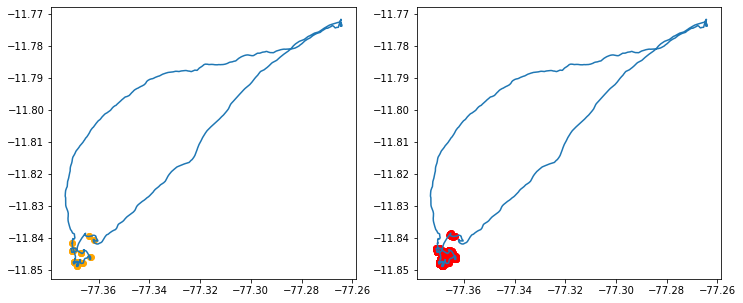

In [22]:
plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[dive_plot == 1], t.lat[dive_plot == 1], c = 'red')

# score

In [23]:
# globally
all_real = 1* (np.hstack(dive_real)> 0)
all_estim = 1* (np.hstack(dive_estim) > 0)

true_positive = np.mean(all_estim[all_real == 1])
true_negative = 1-np.mean(all_estim[all_real == 0])

true_positive, true_negative

(0.6373626373626373, 0.8603880738286795)

(0.7142857142857143, 0.8944099378881988)
(0.6666666666666666, 0.9007633587786259)
(0.5, 0.9009584664536742)
(0.4827586206896552, 0.8222222222222222)
(0.8, 0.776)
(0.6666666666666666, 0.8154761904761905)
(0.7857142857142857, 0.8700361010830325)


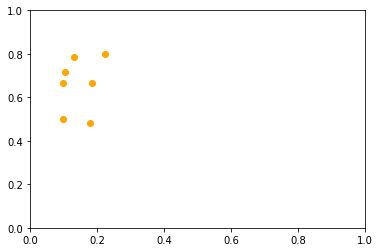

In [24]:
# for each trip
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for i in range(len(dive_real)):
    
    real = 1*(dive_real[i]>0)
    estim = 1*(dive_estim[i]>0)
    
    true_positive = np.mean(estim[real == 1])
    true_negative = 1-np.mean(estim[real == 0])

    ax.scatter(1-true_negative, true_positive, c = 'orange')
    
    print((true_positive, true_negative))

# ROC curve

In [25]:
# globally
TP = []
FP = []

all_real = 1* (np.hstack(dive_real)> 0)    
for tt in np.arange(-50, 50, 0.1):
    all_estim = 1* (np.hstack(dive_estim) > tt)
    true_positive = np.mean(all_estim[all_real == 1])
    true_negative = 1-np.mean(all_estim[all_real == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

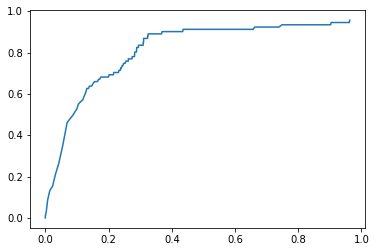

In [26]:
plt.plot(np.array(FP), np.array(TP))

In [27]:
data = {'model': 'network_timeseries',
        'FP':  FP,
        'TP': TP
        }

df = pd.DataFrame (data, columns = ['model','FP','TP'])

df.to_csv('roc_network_timeseries.csv', index = False)
# df.to_csv('./roc/roc_network_timeseries.csv', index = False)

# Export Probabilities

In [46]:
all_real = np.hstack(dive_real)
all_estim = np.hstack(dive_estim)
all_proba_estim = 1/(1+np.exp(-all_estim))
all_proba_estim

array([3.43097703e-01, 1.30770364e-01, 6.58512023e-02, ...,
       5.11475585e-10, 1.45226151e-06, 4.56196303e-03])

In [47]:
trip_name = data_test.trip.unique()
trip_length = [len(i) for i in dive_estim]
trip = [trip_name[i] for i in range(len(trip_name)) for k in range(trip_length[i])]

In [49]:
data = {'model': 'network_timeseries',
        'trip':  trip,
        'real': all_real,
        'p': all_proba_estim
        }

df = pd.DataFrame (data, columns = ['model','trip', 'real', 'p'])

df.to_csv('prob_network_timeseries.csv', index = False)